In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import data_challenge_library as dcl
import matplotlib as mpl
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
object_table = dcl.load_table(features = "important", remove_unlabeled = True)

Original Table has 446487 sources
Keeping 432767 labeled sources
Keeping only the required 325 features
Keeping 111453 with all features available
class
Star    52999
Qso     30853
Gal     27339
Agn       262
Name: count, dtype: int64


In [3]:
with open(os.path.join("input_files", "variability_features.dat"), 'r') as f:
            variability_list = [line.strip("\n") for line in f]
with open(os.path.join("input_files", "photometry_features.dat"), 'r') as f:
            photometry_list = [line.strip("\n") for line in f]

In [4]:
v_train, v_validation, v_test = dcl.prepare_sample(object_table[variability_list], test_size = 0.1, validation_size = 0.5)
p_train, p_validation, p_test = dcl.prepare_sample(object_table[photometry_list], test_size = 0.1, validation_size = 0.5)

Returning train, validation and test objects
Returning train, validation and test objects


In [5]:
var_classifier = CatBoostClassifier()
var_classifier.fit(v_train.X, v_train.y)

Learning rate set to 0.096614
0:	learn: 0.9425254	total: 102ms	remaining: 1m 42s
1:	learn: 0.8229474	total: 149ms	remaining: 1m 14s
2:	learn: 0.7279082	total: 201ms	remaining: 1m 6s
3:	learn: 0.6491183	total: 245ms	remaining: 1m
4:	learn: 0.5845428	total: 290ms	remaining: 57.7s
5:	learn: 0.5288711	total: 355ms	remaining: 58.8s
6:	learn: 0.4818360	total: 425ms	remaining: 1m
7:	learn: 0.4409931	total: 469ms	remaining: 58.1s
8:	learn: 0.4059135	total: 510ms	remaining: 56.2s
9:	learn: 0.3748792	total: 556ms	remaining: 55s
10:	learn: 0.3476676	total: 605ms	remaining: 54.4s
11:	learn: 0.3234621	total: 650ms	remaining: 53.5s
12:	learn: 0.3015829	total: 699ms	remaining: 53.1s
13:	learn: 0.2824394	total: 745ms	remaining: 52.5s
14:	learn: 0.2654542	total: 785ms	remaining: 51.6s
15:	learn: 0.2503955	total: 822ms	remaining: 50.6s
16:	learn: 0.2368004	total: 871ms	remaining: 50.4s
17:	learn: 0.2244363	total: 915ms	remaining: 49.9s
18:	learn: 0.2136700	total: 969ms	remaining: 50s
19:	learn: 0.203644

In [6]:
phot_classifier = CatBoostClassifier()
phot_classifier.fit(p_train.X, p_train.y)


Learning rate set to 0.096614
0:	learn: 0.9456491	total: 14.8ms	remaining: 14.8s
1:	learn: 0.8302425	total: 25.2ms	remaining: 12.6s
2:	learn: 0.7364446	total: 34.9ms	remaining: 11.6s
3:	learn: 0.6617961	total: 43.6ms	remaining: 10.9s
4:	learn: 0.6000043	total: 52.2ms	remaining: 10.4s
5:	learn: 0.5455359	total: 60.5ms	remaining: 10s
6:	learn: 0.4990040	total: 68.8ms	remaining: 9.75s
7:	learn: 0.4593363	total: 77.1ms	remaining: 9.55s
8:	learn: 0.4235025	total: 86ms	remaining: 9.47s
9:	learn: 0.3928803	total: 95ms	remaining: 9.4s
10:	learn: 0.3661110	total: 103ms	remaining: 9.29s
11:	learn: 0.3424103	total: 112ms	remaining: 9.2s
12:	learn: 0.3221595	total: 121ms	remaining: 9.21s
13:	learn: 0.3036025	total: 129ms	remaining: 9.1s
14:	learn: 0.2872527	total: 137ms	remaining: 9s
15:	learn: 0.2724804	total: 145ms	remaining: 8.92s
16:	learn: 0.2587630	total: 154ms	remaining: 8.89s
17:	learn: 0.2453843	total: 162ms	remaining: 8.82s
18:	learn: 0.2344576	total: 170ms	remaining: 8.75s
19:	learn: 0.

In [7]:
v_predictions = var_classifier.predict(v_validation.X)
p_predictions = phot_classifier.predict(p_validation.X)

In [8]:
cm_v = confusion_matrix(v_validation.y, v_predictions, normalize = "true")
cm_p = confusion_matrix(p_validation.y, p_predictions, normalize = "true")
print(cm_v.diagonal()/cm_v.sum(axis=1), accuracy_score(v_validation.y, v_predictions))
print(cm_p.diagonal()/cm_p.sum(axis=1), accuracy_score(p_validation.y, p_predictions))

[0.98780386 0.96780241 0.95857693] 0.9747378075527375
[0.99220453 0.96397131 0.96142878] 0.9766917892889899


Text(0.5, 1.0, 'Variability')

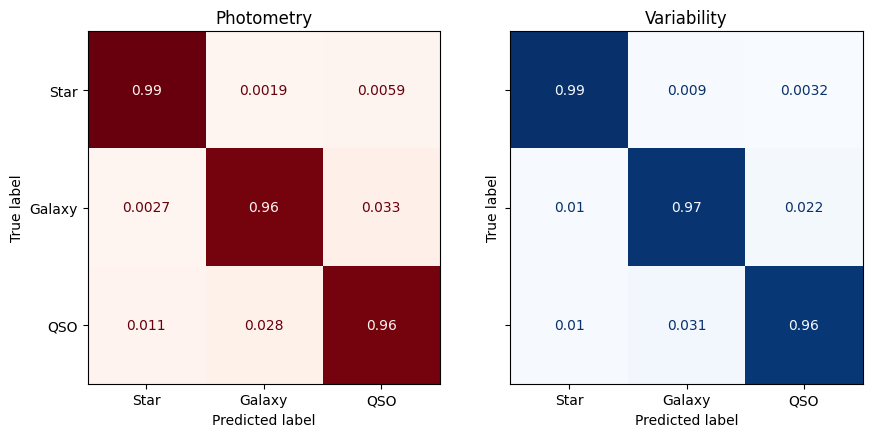

In [9]:
str_labels = ["Star", "Galaxy", "QSO"]
cm_p_display = ConfusionMatrixDisplay(cm_p, display_labels=str_labels);
cm_v_display = ConfusionMatrixDisplay(cm_v, display_labels=str_labels);
fig, ax = plt.subplots(ncols=2, figsize = (10,9), sharey = True)
cm_v_display.plot(ax=ax[1], cmap = mpl.cm.Blues, colorbar = False)
cm_p_display.plot(ax=ax[0], cmap = mpl.cm.Reds, colorbar = False)
ax[0].set_title("Photometry")
ax[1].set_title("Variability")
#plt.savefig(f"plots_angelica/cf_{name}.png", bbox_inches = "tight")

In [10]:
import utility_library as ulb
from sklearn.preprocessing import LabelBinarizer

In [11]:
def cross_entropy(predictions, targets, epsilon=1e-8):
    predictions = np.clip(predictions, epsilon, 1-epsilon)
    return (-np.log(predictions) * targets).sum(axis=1).mean()

In [12]:
v_probabilities = var_classifier.predict_proba(v_validation.X)
p_probabilities = phot_classifier.predict_proba(p_validation.X)

In [13]:
y_hats = {"variability" :  v_probabilities,
          "photometry"  : p_probabilities}

In [17]:
enc = LabelBinarizer()
max_iter = 100
ensemble_loss, model_weights = ulb.ensemble_selector(loss_function= cross_entropy, 
                                                     y_hats = y_hats,
                                                     y_true=enc.fit_transform(v_validation.y), init_size=1, 
                                                    replacement=True, max_iter=max_iter)

In [19]:
vt_probabilities = var_classifier.predict_proba(v_test.X)
pt_probabilities = phot_classifier.predict_proba(p_test.X)

ensemble_predictions = ulb.voting_predictions(*(vt_probabilities,pt_probabilities), weights =model_weights.iloc[max_iter,:].to_numpy())

/home/saccheo/WORK/challenge/utility_library.py:124: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights=="equal":


In [22]:
cm = confusion_matrix(v_test.y, ensemble_predictions, normalize = "true")
print(cm.diagonal()/cm.sum(axis = 1), accuracy_score(v_test.y, ensemble_predictions))

[0.99268978 0.96611446 0.96925515] 0.9797236676834739


Text(0.5, 1.0, 'Ensemble')

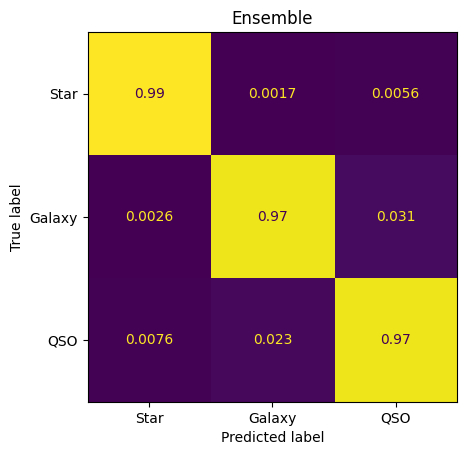

In [23]:
cm_display = ConfusionMatrixDisplay(cm, display_labels = str_labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax, cmap = mpl.cm. viridis, colorbar = False)
ax.set_title("Ensemble")

In [24]:
train, validation, test = dcl.prepare_sample(object_table, test_size = 0.1, validation_size = 0.5)

Returning train, validation and test objects


In [25]:
classifier = CatBoostClassifier()
classifier.fit(train.X, train.y)
predictions = classifier.predict(test.X)

Learning rate set to 0.096614
0:	learn: 0.9369813	total: 90.6ms	remaining: 1m 30s
1:	learn: 0.8121769	total: 186ms	remaining: 1m 32s
2:	learn: 0.7118079	total: 280ms	remaining: 1m 33s
3:	learn: 0.6315497	total: 390ms	remaining: 1m 37s
4:	learn: 0.5648063	total: 477ms	remaining: 1m 34s
5:	learn: 0.5078068	total: 582ms	remaining: 1m 36s
6:	learn: 0.4588827	total: 710ms	remaining: 1m 40s
7:	learn: 0.4166492	total: 806ms	remaining: 1m 39s
8:	learn: 0.3805349	total: 912ms	remaining: 1m 40s
9:	learn: 0.3487954	total: 1.03s	remaining: 1m 42s
10:	learn: 0.3208719	total: 1.13s	remaining: 1m 41s
11:	learn: 0.2954319	total: 1.28s	remaining: 1m 45s
12:	learn: 0.2724509	total: 1.36s	remaining: 1m 43s
13:	learn: 0.2525393	total: 1.47s	remaining: 1m 43s
14:	learn: 0.2349367	total: 1.57s	remaining: 1m 43s
15:	learn: 0.2194788	total: 1.7s	remaining: 1m 44s
16:	learn: 0.2054637	total: 1.8s	remaining: 1m 43s
17:	learn: 0.1926079	total: 1.87s	remaining: 1m 42s
18:	learn: 0.1810936	total: 1.95s	remaining: 

In [26]:
cm_all = confusion_matrix(test.y, predictions, normalize = "true")
print(cm_all.diagonal()/cm_all.sum(axis = 1), accuracy_score(test.y, predictions))


[0.99381443 0.97326807 0.96640254] 0.9811591602368562


Text(0.5, 1.0, 'All features')

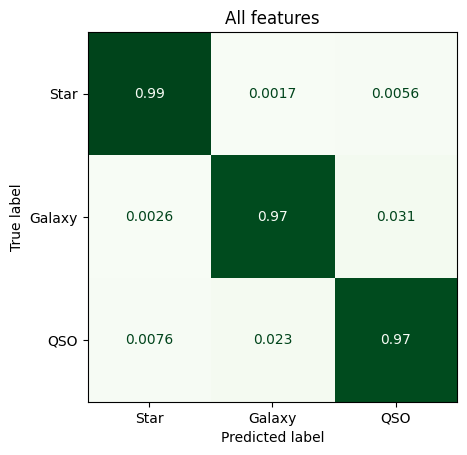

In [27]:
cm_display = ConfusionMatrixDisplay(cm_all, display_labels = str_labels)
fig, ax = plt.subplots()
cm_display.plot(ax=ax, cmap = mpl.cm.Greens, colorbar = False)
ax.set_title("All features")